In [1]:
from torch.distributions import Normal
import torch.optim as optim
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import gymnasium
import imageio
import random

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, action_dim)
        )
        self.log_std = nn.Parameter(torch.zeros(action_dim))

    def forward(self, state):
        mean = self.network(state)
        log_std = self.log_std.expand_as(mean)
        std = torch.exp(log_std)
        return Normal(mean, std)


class ValueNetwork(nn.Module):
    def __init__(self, state_dim):
        super(ValueNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, state):
        return self.network(state)

In [4]:
class PPO:
    def __init__(self, state_dim, action_dim, clip_eps):
        self.gamma = 0.99  # discount factor
        self.lam = 0.95  # lambda for GAE
        self.num_epochs = 10
        self.minibatch_size = 64
        self.clip_eps = clip_eps
        self.policy_net = PolicyNetwork(state_dim, action_dim)
        self.val_net = ValueNetwork(state_dim)
        self.learning_rate = 3e-4
        self.policy_optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.value_optimizer = optim.Adam(self.val_net.parameters(), lr=self.learning_rate)

    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        dist = self.policy_net(state)
        action = dist.sample().squeeze(0)
        log_prob = dist.log_prob(action).squeeze()
        return action.numpy(), log_prob

    def compute_rewards_to_go(self, rewards):
        rtg = []
        discounted_sum = 0
        for reward in reversed(rewards):
            discounted_sum = reward + self.gamma * discounted_sum
            rtg.insert(0, discounted_sum)
        return torch.tensor(rtg)

    def compute_advantages(self, states, rewards):
        values = self.val_net(states).squeeze().detach()

        T = len(rewards)
        advantages = torch.zeros(T, dtype=torch.float32)
        gae = 0.0
        for t in reversed(range(T - 1)):
            td_error = rewards[t] + self.gamma * values[t + 1] - values[t]
            gae = td_error + self.gamma * self.lam * gae
            advantages[t] = gae

        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-10)
        return advantages

    def update(self, states, actions, log_probs_old, advantages, rewards_to_go):
        total_samples = states.size(0)

        for _ in range(self.num_epochs):
            perm = torch.randperm(total_samples)

            states_perm, actions_perm, log_probs_old_perm, advantages_perm, rewards_to_go_perm = \
                states[perm], actions[perm], log_probs_old[perm], advantages[perm], rewards_to_go[perm]

            # Process each minibatch
            for i in range(0, total_samples, self.minibatch_size):
                states_batch = states_perm[i:i + self.minibatch_size]
                actions_batch = actions_perm[i:i + self.minibatch_size]
                log_probs_old_batch = log_probs_old_perm[i:i + self.minibatch_size]
                advantages_batch = advantages_perm[i:i + self.minibatch_size]
                rewards_to_go_batch = rewards_to_go_perm[i:i + self.minibatch_size]

                # Recompute distribution for current policy
                dist = self.policy_net(states_batch)
                new_log_probs = dist.log_prob(actions_batch).squeeze()

                # Calculate the ratio of new to old probabilities
                ratios = torch.exp(new_log_probs - log_probs_old_batch)

                # Clipping the ratio to stabilize training
                clipped_ratios = torch.clamp(ratios, 1 - self.clip_eps, 1 + self.clip_eps)

                # Calculate the clipped and unclipped objective
                unclipped_objective = ratios * advantages_batch
                clipped_objective = clipped_ratios * advantages_batch

                # Negative sign to run gradient ascent
                policy_loss = -torch.min(unclipped_objective, clipped_objective).mean()

                values = self.val_net(states_batch).squeeze()

                # Value loss
                value_loss = nn.MSELoss()(values, rewards_to_go_batch)

                # Optimize policy
                self.policy_optimizer.zero_grad()
                policy_loss.backward()
                self.policy_optimizer.step()

                # Optimize value
                self.value_optimizer.zero_grad()
                value_loss.backward()
                self.value_optimizer.step()

In [5]:
clip_epsilons = [0.1, 0.2, 0.3]
seeds = [1, 2, 3, 5, 8]
num_episodes = 1000

results = {}

for eps in clip_epsilons:
    env = gymnasium.make("InvertedPendulum-v4", render_mode="rgb_array")
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]

    rewards_over_seeds = []

    for seed in seeds:
        torch.manual_seed(seed)
        random.seed(seed)
        np.random.seed(seed)

        agent = PPO(state_dim, action_dim, clip_eps=eps)
        rewards_over_episodes = []

        for episode in range(1, num_episodes + 1):
            states, actions, rewards, log_probs = [], [], [], []

            state, _ = env.reset(seed=seed)
            done = False

            while not done:
                action, log_prob = agent.select_action(state)
                next_state, reward, terminated, truncated, info = env.step(action)

                states.append(state)
                actions.append(action)
                rewards.append(reward)
                log_probs.append(log_prob)

                done = terminated or truncated
                state = next_state

            states, actions, rewards, log_probs = torch.FloatTensor(np.vstack(states)), torch.FloatTensor(
                np.vstack(actions)), rewards, torch.FloatTensor(log_probs)

            episode_reward = sum(rewards)
            rewards_over_episodes.append(episode_reward)

            rewards_to_go = agent.compute_rewards_to_go(rewards)
            advantages = agent.compute_advantages(states, rewards)

            agent.update(states, actions, log_probs, advantages, rewards_to_go)

            if episode % 50 == 0:
                print(f"\r[Epsilon {eps}, Seed {seed}] Episode {episode}: {episode_reward}", end="")

        rewards_over_seeds.append(rewards_over_episodes)

    results[eps] = rewards_over_seeds

[Epsilon 0.3, Seed 8] Episode 1000: 1000.0

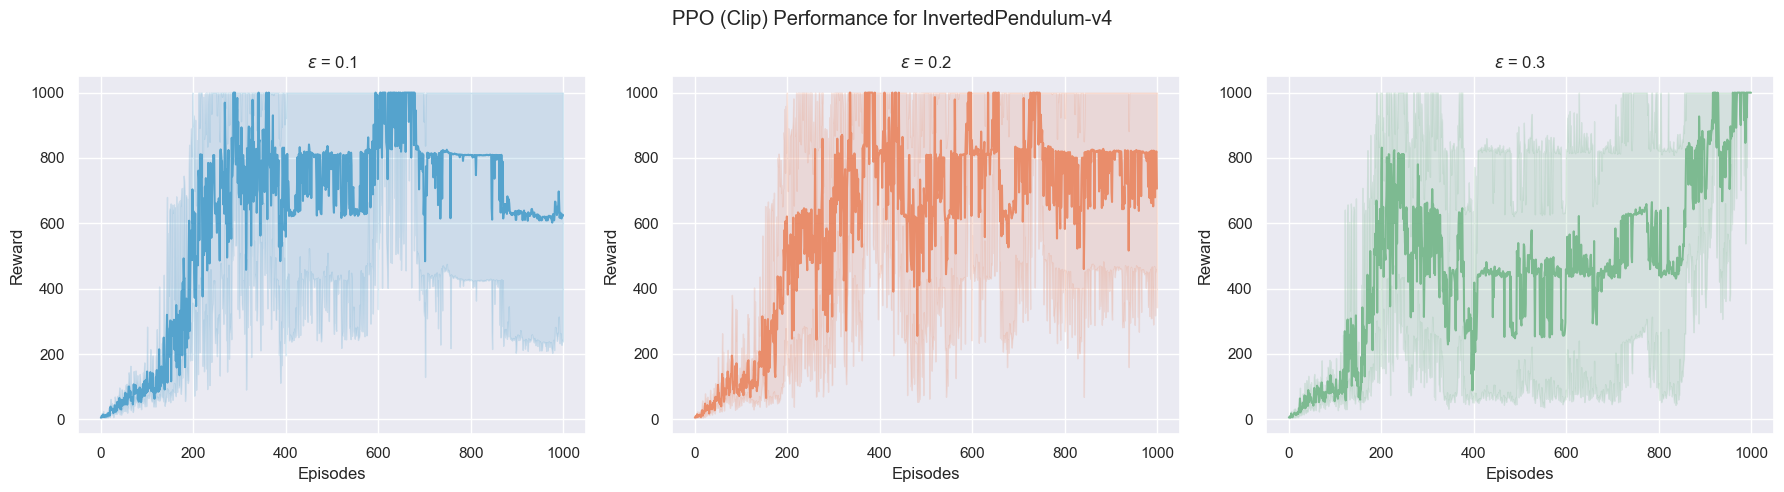

In [9]:
plt.figure(figsize=(18, 5))

for i, ((clip_eps, rewards), palette) in enumerate(zip(results.items(), ["flare", "crest", "icefire"])):
    plt.subplot(1, 3, i + 1)
    df = pd.DataFrame(rewards).melt()
    df.rename(columns={"variable": "Episodes", "value": "Reward"}, inplace=True)
    sns.set(style="darkgrid", palette=palette)
    ax = sns.lineplot(x="Episodes", y="Reward", data=df)
    ax.set(title=f"$\epsilon$ = {clip_eps}")

plt.suptitle("PPO (Clip) Performance for InvertedPendulum-v4")
plt.tight_layout()
plt.show()

In [7]:
clip_eps_avg_last_100 = {clip_eps: np.mean([np.mean(seed_rewards[-100:]) for seed_rewards in rewards])
                         for clip_eps, rewards in results.items()}

In [8]:
for clip_eps, avg_last_100 in clip_eps_avg_last_100.items():
    print(f"Clipping, ε={clip_eps}: {avg_last_100:.3f}")

Clipping, ε=0.1: 626.554
Clipping, ε=0.2: 771.524
Clipping, ε=0.3: 894.720
